# Azure

In [4]:

import random

import numpy
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

In [5]:
endpoint = "https://nlpnavadarucalin.cognitiveservices.azure.com/"
key = "4e07f5fc3192462eacc190286a86f426"

client = TextAnalyticsClient(endpoint=endpoint, credential=AzureKeyCredential(key))

In [6]:
message1 = [
    "By choosing a bike over a car, I’m reducing my environmental footprint. Cycling promotes eco-friendly transportation, and I’m proud to be part of that movement.."]

result = client.analyze_sentiment(message1, show_opinion_mining=True)
docs = [doc for doc in result if not doc.is_error]

for idx, doc in enumerate(docs):
    print(doc.sentiment)

positive


In [7]:
import pandas as pd

data = pd.read_csv("data/reviews_mixed.csv")
data

,Text,Sentiment
0,"The rooms are extremely small, practically onl...",negative
1,Room safe did not work.,negative
2,Mattress very comfortable.,positive
3,"Very uncomfortable, thin mattress, with plasti...",negative
4,No bathroom in room,negative
...,...,...
202,Crumbs from snacks were not cleaned up for 3 d...,negative
203,the bathroom was a little dirty with hair at t...,negative
204,We had requested two queen beds and got a room...,negative
205,Noisy noisy suite on 4th floor.,negative


In [8]:
list_reviews = data['Text'].to_list()
sentiments_reviews = data['Sentiment'].to_list()
ground_truth = pd.factorize(data['Sentiment'])

In [9]:
predicted = []
for id_review, values in enumerate(zip(list_reviews, sentiments_reviews)):
    review, sentiment = values
    result_reviews = client.analyze_sentiment([review], show_opinion_mining=True)
    result_docs = [doc for doc in result_reviews if not doc.is_error]
    for review_text in result_docs:
        print(f'Review: {review} -> {review_text.sentiment}')
        if review_text.sentiment == "positive":
            predicted.append(1)
        else:
            predicted.append(0)

Review: The rooms are extremely small, practically only a bed. -> negative
Review: Room safe did not work. -> negative
Review: Mattress very comfortable. -> positive
Review: Very uncomfortable, thin mattress, with plastic cover that rustles every time you move. -> negative
Review: No bathroom in room -> negative
Review: The bed was soooo comfy. -> positive
Review: someone must have been smoking in the room next door. -> neutral
Review: The bed is very comfortable. -> positive
Review: Very spacious rooms, quiet and very comfortable. -> positive
Review: For 3 people in a bedroom the sofa bed is a bit unconfortable. -> negative
Review: Lights in the common room were too dim. -> negative
Review: Air conditioning working fine. -> positive
Review: So if you're the type that likes to let water run a bit before getting wet or it takes a minute to figure out how to make it hot, you're gonna get wet. -> neutral
Review: the windows are only single glazed so the heat could escape- although to be f

In [10]:
print(predicted)
ground_truth = ground_truth[0]
print(ground_truth)

[0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0]
[0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0
 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1
 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0
 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0
 1 

In [11]:
from sklearn.metrics import accuracy_score

print(f'Accuracy {accuracy_score(predicted, ground_truth)}')

Accuracy 0.8985507246376812


# k-Means Library

In [12]:
from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin", binary=True)

msg = message1[0].split()
result = 0
for word in msg:
    word = word.strip()
    result += word2vec_model[word] if len(word) > 2 and word in word2vec_model.index_to_key else 0

result = result / len(msg)
print(result)

[-0.04304077  0.04303711  0.00933838 -0.00063477  0.0042334   0.00563599
  0.0444519  -0.03330322  0.04454102  0.05844238 -0.00289063 -0.03786377
  0.00310547  0.00273193  0.00834961  0.01220337 -0.03130127  0.04852539
 -0.0118988   0.03140137 -0.00813133  0.06179687 -0.02397217  0.024077
  0.00498535 -0.00852646 -0.05765503  0.03287842  0.0245813  -0.01949707
  0.02625366 -0.01031738  0.0034375   0.02036133  0.01613769 -0.04096191
  0.01537331 -0.04107178  0.01603027  0.02294434  0.00482422  0.00379395
  0.00846588  0.02636231 -0.05333008 -0.0294751  -0.01579834  0.03224976
  0.01113892  0.02836182  0.01843262  0.03191528  0.00327148  0.00170166
  0.03438476  0.02916992 -0.06543457 -0.05528198  0.01521912 -0.02749023
  0.00321289  0.03508789 -0.05106445 -0.0327832   0.0144165  -0.01025879
 -0.03026856  0.03092041 -0.00800049  0.01854981 -0.00800934  0.02458496
  0.01207275 -0.01600586 -0.0347937  -0.05670898  0.05134     0.00733521
 -0.02066895  0.0239624  -0.00335114 -0.03385254 -0.0

In [13]:
from random import shuffle

indexes = [i for i in range(len(list_reviews))]
shuffle(indexes)
train_indexes = indexes[:int(0.78 * len(indexes))]
train_input = [list_reviews[i] for i in train_indexes]
test_input = [list_reviews[i] for i in indexes if i not in train_indexes]
test_output = [ground_truth[i] for i in indexes if i not in train_indexes]

In [14]:
import numpy as np


def train_feature_w2v(data_arg):
    result_list = []
    for prop in data_arg:
        feature = 0
        list_words = prop.split()
        for word_arg in list_words:
            word_arg = word_arg.strip()
            if word_arg in word2vec_model.index_to_key and len(word_arg) > 2:
                feature += np.mean(word2vec_model[word_arg])
            else:
                feature += 0

        feature = feature / len(list_words)
        result_list.append(feature)

    return numpy.array(result_list).reshape(-1, 1)

In [15]:
train_input = train_feature_w2v(train_input)
test_input = train_feature_w2v(test_input)

In [16]:
from sklearn.cluster import KMeans

unsupervisedClassifier = KMeans(n_clusters=2, random_state=0)
unsupervisedClassifier.fit(train_input)

KMeans(n_clusters=2, random_state=0)

In [17]:
predicted = unsupervisedClassifier.predict(test_input)
print(predicted)

from sklearn.metrics import accuracy_score

print(f'Accuracy {accuracy_score(predicted, test_output)}')

[0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0
 1 1 0 1 0 0 0 1 0]
Accuracy 0.41304347826086957


# Caracteristici Text

#### Word2Vec

In [18]:
print(train_feature_w2v(list_reviews))

[[ 5.51530302e-04]
 [-7.89918203e-03]
 [ 1.20708719e-04]
 [-2.91614156e-03]
 [-7.80057933e-04]
 [ 5.53961648e-03]
 [-2.62512314e-03]
 [ 2.77012633e-03]
 [ 1.75775335e-03]
 [ 2.14963463e-03]
 [-1.25564337e-03]
 [-3.25449929e-03]
 [ 1.70277354e-04]
 [ 2.73243503e-05]
 [-3.33943526e-03]
 [-3.25928880e-03]
 [-6.41692671e-03]
 [-5.50329452e-04]
 [ 2.50389640e-03]
 [ 5.01922425e-04]
 [ 1.73737276e-03]
 [ 4.86911105e-04]
 [-1.19704101e-02]
 [ 2.10887007e-03]
 [-8.66632021e-04]
 [-6.48121926e-04]
 [ 0.00000000e+00]
 [ 4.08136332e-04]
 [-2.84907816e-04]
 [-5.87699326e-03]
 [-4.96243418e-03]
 [-1.73921904e-03]
 [ 3.42458079e-04]
 [ 1.63113062e-03]
 [ 3.65401038e-03]
 [ 2.33177184e-03]
 [-3.39563545e-03]
 [-2.45665410e-03]
 [-7.14185483e-04]
 [-3.62016747e-04]
 [-1.05173533e-03]
 [ 1.53841526e-04]
 [-1.07705919e-04]
 [-6.01600924e-04]
 [-2.24175480e-03]
 [-1.68062594e-03]
 [-1.56398816e-03]
 [-1.67012852e-03]
 [ 4.63997247e-04]
 [-2.45256618e-03]
 [ 1.85435027e-03]
 [-3.21402098e-04]
 [ 3.9069820

#### Bag of words

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

In [20]:
indexes = [i for i in range(len(list_reviews))]
shuffle(indexes)
train_indexes = indexes[:int(0.78 * len(indexes))]
train_input = [list_reviews[i] for i in train_indexes]
test_input = [list_reviews[i] for i in indexes if i not in train_indexes]

In [21]:
train_input = vectorizer.fit_transform(train_input)
test_input = vectorizer.transform(test_input)

In [22]:
print(type(train_input))

<class 'scipy.sparse._csr.csr_matrix'>


In [23]:
print("vocab size: ", len(vectorizer.vocabulary_), " words")
print("trainFeatures shape: ", train_input.shape)

print('some words of the vocab: ', vectorizer.get_feature_names_out()[-20:])
print('some features: ', train_input.toarray()[:3])

vocab size:  552  words
trainFeatures shape:  (161, 552)
some words of the vocab:  ['were' 'what' 'when' 'which' 'whole' 'whomever' 'wifi' 'window' 'windows'
 'with' 'work' 'worked' 'working' 'workout' 'works' 'would' 'years' 'you'
 'your' 'yr']
some features:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### TF-IDF

In [24]:
indexes = [i for i in range(len(list_reviews))]
shuffle(indexes)
train_indexes = indexes[:int(0.78 * len(indexes))]
train_input = [list_reviews[i] for i in train_indexes]
test_input = [list_reviews[i] for i in indexes if i not in train_indexes]

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=50)

trainFeatures = vectorizer.fit_transform(train_input)
testFeatures = vectorizer.transform(test_input)

print('vocab: ', vectorizer.get_feature_names_out()[:10])
print('features: ', trainFeatures.toarray()[:3])

vocab:  ['and' 'are' 'as' 'at' 'bathroom' 'be' 'bed' 'clean' 'coffee'
 'comfortable']
features:  [[0.         0.         0.         0.         0.44287434 0.
  0.         0.         0.         0.         0.         0.36177099
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.41217578 0.         0.         0.         0.
  0.         0.66621965 0.         0.         0.         0.
  0.24340619 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.46679612 0.         0.         0.53113217 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.53113217 0.
  0.         0.         0.    

## Extra 

#### CBOW

In [26]:
indexes = [i for i in range(len(list_reviews))]
shuffle(indexes)
train_indexes = indexes[:int(0.78 * len(indexes))]
train_input = [list_reviews[i] for i in train_indexes]

In [27]:
from nltk import word_tokenize

train_input = [word_tokenize(review) for review in train_input]

In [28]:
from gensim.models import Word2Vec

cbow_model = Word2Vec(train_input, min_count=1, window=5, sg=0)

cbow_model.train(train_input, total_examples=len(train_input), epochs=100)
print(cbow_model.wv)

KeyedVectors<vector_size=100, 644 keys>


#### Cosine Similarity

In [29]:
propozitia1 = "Eu sunt Calin."
propozitia2 = "Eu nu sunt Calin, sunt Marius."

distance = word2vec_model.wmdistance(propozitia1, propozitia2)
print(distance)

0.18761169147478268


# K-means manual

In [69]:
import math


def euclidian_distance(a, b):
    sum_value = 0
    for elem_a, elem_b in zip(a, b):
        sum_value += (elem_a - elem_b) ** 2
    return math.sqrt(np.sum(sum_value))

In [70]:
def stop(old_c, c, no_iteration):
    if no_iteration > 10000:
        return True
    return old_c == c


class KMeans:

    def __init__(self, input_size, number_of_classes):
        self.input_size = input_size
        self.centroids = None
        self.number_of_classes = number_of_classes

    def fit(self, train_data_arg):
        values_random = random.sample(list(train_data_arg), self.number_of_classes)
        self.centroids = np.array([[x] for x in values_random])
        no_iteration = 0
        old_c = None
        c = []
        while not stop(old_c, c, no_iteration):
            old_c = c.copy()
            c = []
            no_iteration += 1
            for i in range(len(train_data_arg)):
                # c_min = np.linalg.norm(self.centroids[0] - train_data_arg[i])
                c_min = euclidian_distance(self.centroids[0], train_data_arg[i])
                c_index = 0
                for j in range(1, len(self.centroids)):
                    # d = np.linalg.norm(self.centroids[j] - train_data_arg[i])
                    d = euclidian_distance(self.centroids[j], train_data_arg[i])
                    if c_min > d:
                        c_index = j
                        c_min = d
                c.append(c_index)

            for j in range(len(self.centroids)):
                denominator = 0
                numerator = 0
                for i in range(len(c)):
                    if c[i] == j:
                        numerator += train_data_arg[i]
                        denominator += 1

                self.centroids[j] = numerator / denominator if denominator != 0 \
                    else train_data_arg[random.randint(0, len(train_data_arg) - 1)]

    def predict(self, test_data_arg):
        result_predict = []
        for i in range(len(test_data_arg)):
            c_min = np.linalg.norm(self.centroids[0] - test_data_arg[i])
            c_index = 0
            for j in range(1, len(self.centroids)):
                d = euclidian_distance(self.centroids[j], test_data_arg[i])
                if c_min > d:
                    c_index = j
                    c_min = d

            result_predict.append(c_index)

        return result_predict

In [71]:
from random import shuffle

indexes = [i for i in range(len(list_reviews))]
shuffle(indexes)
train_indexes = indexes[:int(0.75 * len(indexes))]
train_input = [list_reviews[i] for i in train_indexes]
test_input = [list_reviews[i] for i in indexes if i not in train_indexes]
test_output = [ground_truth[i] for i in indexes if i not in train_indexes]

train_input = train_feature_w2v(train_input)
test_input = train_feature_w2v(test_input)

In [72]:
unsupervisedClassifier = KMeans(1, 2)
unsupervisedClassifier.fit(train_input)
predicted = unsupervisedClassifier.predict(test_input)

from sklearn.metrics import accuracy_score

print(f'Accuracy {accuracy_score(predicted, test_output)}')

Accuracy 0.5


# Alternative la K-means

In [73]:
from random import shuffle

indexes = [i for i in range(len(list_reviews))]
shuffle(indexes)
train_indexes = indexes[:int(0.75 * len(indexes))]
train_input = [list_reviews[i] for i in train_indexes]
test_input = [list_reviews[i] for i in indexes if i not in train_indexes]
test_output = [ground_truth[i] for i in indexes if i not in train_indexes]

train_input = train_feature_w2v(train_input)
test_input = train_feature_w2v(test_input)

Number of estimated clusters: 3
[[-0.00127455]
 [-0.00955955]
 [-0.01650272]]


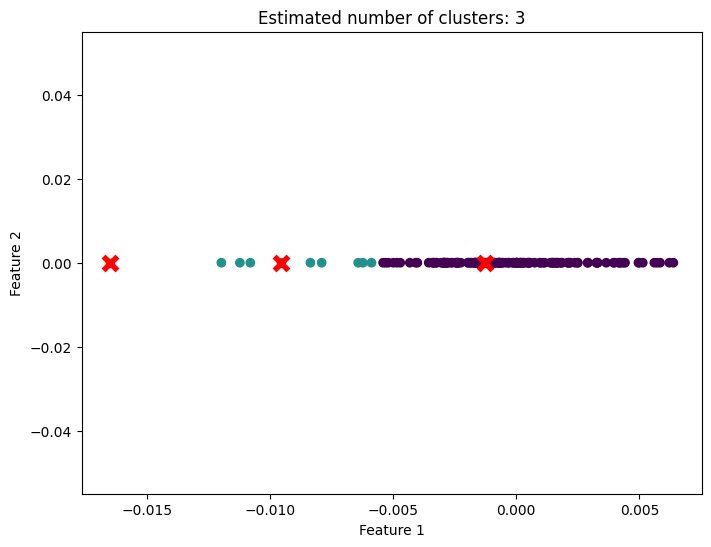

In [74]:
from matplotlib import pyplot as plt
from sklearn.cluster import MeanShift

# Apply Mean Shift clustering
ms = MeanShift()
ms.fit(train_input)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

# Number of clusters
n_clusters = len(np.unique(labels))

print("Number of estimated clusters:", n_clusters)
print(cluster_centers)
# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(train_input[:, 0], np.zeros_like(train_input[:, 0]), c=labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], np.zeros_like(cluster_centers), marker='x', color='red', s=100, linewidths=4)
plt.title('Estimated number of clusters: {}'.format(n_clusters))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [75]:
predicted = ms.predict(test_input)
from sklearn.metrics import accuracy_score

print(f'Accuracy {accuracy_score(predicted, test_output)}')

Accuracy 0.6923076923076923


In [76]:
from random import shuffle

indexes = [i for i in range(len(list_reviews))]
shuffle(indexes)
train_indexes = indexes[:int(0.75 * len(indexes))]
train_input = [list_reviews[i] for i in train_indexes]
test_input = [list_reviews[i] for i in indexes if i not in train_indexes]
test_output = [ground_truth[i] for i in indexes if i not in train_indexes]

train_input = train_feature_w2v(train_input)
test_input = train_feature_w2v(test_input)

In [77]:
from sklearn.cluster import SpectralClustering

spectral_clustering = SpectralClustering(n_clusters=1, affinity='nearest_neighbors', random_state=0)
spectral_clustering.fit(train_input)

predicted = spectral_clustering.fit_predict(test_input)

In [78]:
from sklearn.metrics import accuracy_score

print(f'Accuracy {accuracy_score(predicted, test_output)}')

Accuracy 0.6923076923076923
